In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import gc
import functools
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns=100

In [2]:
ROOT_DIR = '../data/instacart/files/'

In [3]:
valid_X = pd.read_csv(ROOT_DIR+'valid_X.csv')
f1_table = pd.read_csv(ROOT_DIR+'f1_table.csv')

In [21]:
print('loading orders')
orders = pd.read_csv(ROOT_DIR+'orders.csv', dtype={
    'order_id':np.int32,
    'user_id':np.int32,
    'eval_set':'category',
    'order_number':np.int16,
    'order_dow':np.int8,
    'order_hour_of_day':np.int8,
    'days_since_prior_order':np.float32
})

loading orders


In [18]:
test = pd.read_csv(ROOT_DIR + 'cleaned_test/test.csv')
test_preds = np.load(ROOT_DIR + 'preds.npy')

In [19]:
test['preds'] = test_preds

In [22]:
threshold = 0.185
d = dict()
for row in test.itertuples():
    if row.preds > threshold:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in orders[orders.eval_set=='test'].order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv(ROOT_DIR+'paulantoine_lgb_starter.csv', index=False)

In [24]:
valid_X = pd.merge(valid_X, f1_table[['user_id', 'y_thr']], on='user_id', how='left')

In [25]:
def get_f1score(x, threshold=0.185):
    y_true = np.concatenate([x.loc[x.reordered==1, 'product_id']])
    if len(y_true) == 0:
        y_true = ['None']
    
    y_pred = np.concatenate([x.loc[x.predicted>threshold, 'product_id']])
    if len(y_pred) == 0:
        y_pred = ['None']
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / float((precision + recall))

In [33]:
t = valid_X.groupby('user_id').apply(get_f1score).reset_index()
t.columns = ['user_id', 'f1']
t = pd.merge(t, valid_X[['user_id', 'days_since_prior_order']].drop_duplicates('user_id'), how='left', on='user_id')

/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


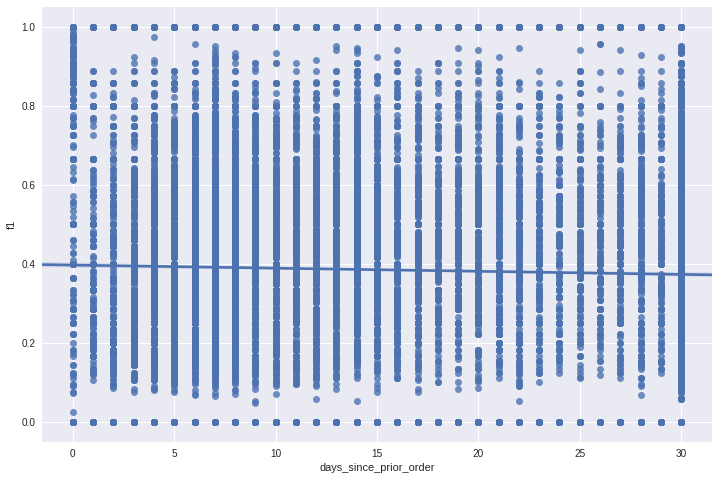

In [34]:
plt.figure(figsize=(12, 8))
sns.regplot(t.days_since_prior_order, t.f1)
plt.show()